**Features**

-	Tenure: Masa waktu berlangganan
-	WarehouseToHome: jarak dari gudang ke rumah pelanggan.
-	NumberOfDeviceRegistered: jumlah total device yang terdaftar.
-	PreferedOrderCat: kategori pesanan yang lebih disukai pelanggan dalam satu bulan terakhir.
-	SatisfactionScore: skor kepuasan pelanggan terhadap pelayanan.
-	MaritalStatus: Status pernikahan.
-	NumberOfAddress: Jumlah total alamat terdaftar.
-	Complaint: komplain pelanggan.
-	DaySinceLastOrder: jumlah hari dari pemesnan terakhir.
-	CashbackAmount: rata - rata cashback berdasarkan satu bulan terakhir
-	Churn: label churn.


## **BUSINESS UNDERSTANDING**


**Context**  
Pada era modern ini, retensi pelanggan merupakan faktor penting dalam kelangsungan bisnis untuk bersaing dengan kompetitor.Karena profitabilitas perusahaan dipengaruhi oleh banyak hal, tetapi tidak ada yang lebih penting daripada retensi pelanggan. Kemampuan untuk mengembangkan dan mempertahankan basis pelanggan yang setia adalah tujuan utama bagi setiap perusahaan, dan metode pembelajaran yang membantu Anda mengurangi dan mencegah pelanggan churn bisa sangat berharga.

Target :

0 : Tidak berhenti berlangganan

1 : Berhenti berlangganan (churn)

**Problem Statement :**

Perusahaan menganggap pelanggan churn sebagai suatu hal yang sangat penting sehingga perusahaan ingin mengetahui pelanggan yang akan berpindah ke lain hati, sehingga mereka dapat melakukan pendekatan kepada pelanggan untuk menawarkan promo.
Sebelum melakukan penawaran promo, perusahaan perlu mengatur strategi supaya promo yang dilakukan tepat sasaran. Promo yang dilakukan tentu tidak diberikan kepada seluruh pelanggan, melainkan yang diprioritaskan adalah pelanggan yang diprediksi akan churn. Hal ini dilakukan untuk melakukan efisiensi terhadap jumlah promo yang dikeluarkan.
Jika perusahaan salah dalam memberikan promo atau asal memberikan promo terhadap pelanggan yang notabene tidak diprediksi churn, tentunya berakibat pada **operation loss** karena `mengeluarkan biaya untuk promo yang sebenernya tidak diperlukan`.


**Goals :**

Maka berdasarkan permasalahan-permasalahan di atas, perusahaan ingin memiliki kemampuan untuk memprediksi kemungkinan seorang pelanggan akan berhenti menggunakan berlanggan atau tidak, sehingga dapat memfokuskan upaya-upaya retensi pada pelanggan yang terindikasi untuk churn.

Dan juga, perusahaan ingin mengetahui faktor-faktor apa saja yang cenderung mempengaruhi pelanggan bertahan, sehingga mereka dapat membuat program-program yang lebih tepat sasaran dalam mengurangi jumlah pelanggan yang churn.

**Analytic Approach :**

Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan pelanggan yang akan berhenti menggunakan berlangganan (churn) atau tidak.

Kemudian kita akan membangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas seorang pelanggan akan berhenti menggunakan berlangganan (churn) atau tidak.

**Metric Evaluation :**

Karena fokus utama kita adalah pelanggan yang akan berhenti menggunakan layanan, maka target yang kita tetapkan adalah sebagai berikut:

Target :
- 0 : Tidak berhenti berlangganan
- 1 : Berhenti berlangganan (churn)

**Type 1 error** : **False Positive**  (pelanggan yang aktualnya tidak churn tetapi diprediksi churn)\
Konsekuensi: operation loss karena mengeluarkan biaya promo untuk pelanggan yang tidak tepat.
Biaya yang dikeluarkan sebesar 50 USD per pelanggan bulan ([sumber](https://sci-hub.se/https://doi.org/10.1016/j.jretconser.2017.10.007)).

**Type 2 error** : **False Negative**  (pelanggan yang aktualnya churn tetapi diprediksi tidak akan churn)\
Konsekuensi: profit loss karena pelanggan churn. Biaya yang dikeluarkan 5x lipat dari biaya promo ke pelanggan     yaitu 250 USD per pelanggan per bulan ([sumber](https://www.superoffice.com/blog/reduce-customer-churn/)).

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengurangi pelanggan churn dari perusahaan tersebut, khususnya jumlah False Negative  pelanggan yang aktualnya churn tetapi diprediksi tidak akan churn), tetapi juga dapat meminimalisir pemberian promo yang tidak tepat. Jadi nanti metric utama yang akan kita gunakan adalah **f2_score**, karena recall kita anggap dua kali lebih penting daripada precision.

## **Load Dataset**

In [280]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

# statistics
from scipy.stats import normaltest

# train test split
from sklearn.model_selection import train_test_split

# menyatukan beberapa tahap preprocessing atau fungsi lainnya
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline

# encoder dan scaler
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# resampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# algoritma ML
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# cross validation untuk menentukan algoritma terbaik
from sklearn.model_selection import cross_val_score, StratifiedKFold

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# metrics untuk klasifikasi
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.metrics import fbeta_score, make_scorer

from xgboost.sklearn import XGBClassifier
from sklearn.metrics import fbeta_score, make_scorer
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind,shapiro


In [281]:
df=pd.read_csv('data_ecommerce_customer_churn.csv')

## **Data Understanding**

In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


In [283]:
display(df.describe(), df.describe(include='object'))

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,3747.000000,3772.000000,3941.000000,3941.000000,3941.000000,3941.000000,3728.000000,3941.000000,3941.000000
mean,10.081398,15.650583,3.679269,3.088302,4.237757,0.282416,4.531652,176.707419,0.171023
std,8.498864,8.452301,1.013938,1.381832,2.626699,0.450232,3.667648,48.791784,0.376576
min,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.000000,3.000000,2.000000,2.000000,0.000000,2.000000,145.700000,0.000000
50%,9.000000,14.000000,4.000000,3.000000,3.000000,0.000000,3.000000,163.340000,0.000000
75%,16.000000,21.000000,4.000000,4.000000,6.000000,1.000000,7.000000,195.250000,0.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,1.000000,46.000000,324.990000,1.000000


,PreferedOrderCat,MaritalStatus
count,3941,3941
unique,6,3
top,Laptop & Accessory,Married
freq,1458,2055


**Missing Values**

In [284]:
df.isna().sum()

Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64

**Duplicated Data**

In [285]:
df.duplicated().sum()

671

**Unique Values**

In [286]:
listItem = []
for col in df.columns :
 
    listItem.append( [col, df[col].nunique(), df[col].unique()   ])

unique_values = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
unique_values

,Column Name,Number of Unique,Unique Sample
0,Tenure,36,"[15.0, 7.0, 27.0, 20.0, 30.0, 1.0, 11.0, 17.0, 6.0, 16.0, 10.0, nan, 8.0, 19.0, 0.0, 3.0, 5.0, 9.0, 18.0, 12.0, 24.0, 4.0, 61.0, 25.0, 13.0, 14.0, 2.0, 21.0, 29.0, 26.0, 23.0, 31.0, 22.0, 28.0, 51.0, 60.0, 50.0]"
1,WarehouseToHome,33,"[29.0, 25.0, 13.0, 15.0, 16.0, 11.0, 12.0, 7.0, 26.0, 20.0, 14.0, 8.0, 21.0, 22.0, 27.0, 18.0, 33.0, 9.0, 17.0, nan, 6.0, 31.0, 28.0, 10.0, 19.0, 32.0, 23.0, 30.0, 35.0, 34.0, 24.0, 5.0, 36.0, 127.0]"
2,NumberOfDeviceRegistered,6,"[4, 3, 6, 2, 5, 1]"
3,PreferedOrderCat,6,"[Laptop & Accessory, Mobile, Fashion, Others, Mobile Phone, Grocery]"
4,SatisfactionScore,5,"[3, 1, 4, 2, 5]"
5,MaritalStatus,3,"[Single, Married, Divorced]"
6,NumberOfAddress,14,"[2, 5, 7, 8, 3, 1, 9, 4, 10, 11, 6, 19, 22, 21]"
7,Complain,2,"[0, 1]"
8,DaySinceLastOrder,22,"[7.0, nan, 8.0, 11.0, 2.0, 1.0, 4.0, 3.0, 6.0, 0.0, 14.0, 9.0, 10.0, 12.0, 5.0, 17.0, 30.0, 18.0, 16.0, 13.0, 15.0, 46.0, 31.0]"
9,CashbackAmount,2335,"[143.32, 129.29, 168.54, 230.27, 322.17, 152.81, 149.51, 154.73, 137.02, 157.43, 221.1, 180.38, 154.09, 231.09, 163.92, 193.15, 121.68, 204.78, 259.96, 127.16, 191.96, 153.01, 126.7, 189.98, 205.95, 148.5, 175.1, 124.32, 204.82, 228.06, 196.13, 205.52, 262.44, 125.46, 123.67, 123.22, 264.73, 122.18, 141.94, 172.87, 139.29, 207.48, 208.92, 296.59, 120.08, 197.64, 151.95, 171.8, 174.84, 152.96, 140.11, 303.75, 226.24, 265.55, 156.47, 179.84, 145.29, 123.68, 268.36, 154.29, 125.64, 144.78, 129.11, 165.31, 135.81, 148.4, 149.5, 136.6, 204.35, 208.46, 125.17, 217.41, 224.9, 211.21, 143.93, 146.68, 167.49, 149.0, 163.49, 145.38, 190.24, 140.69, 188.58, 222.13, 122.7, 141.98, 145.97, 262.34, 140.25, 219.04, 197.56, 179.91, 120.75, 189.66, 110.91, 188.37, 239.16000000000005, 145.08, 179.88, 127.78, ...]"


## **Simple EDA**

**Numerical Features**

In [287]:
numerical_features = df.drop(columns=['Churn']).describe().columns

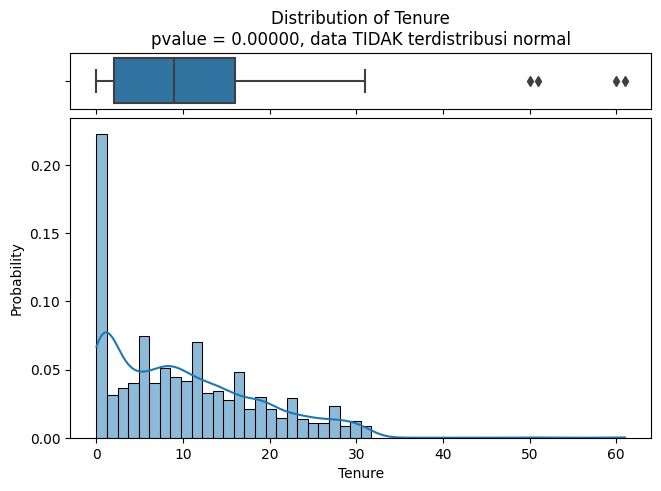

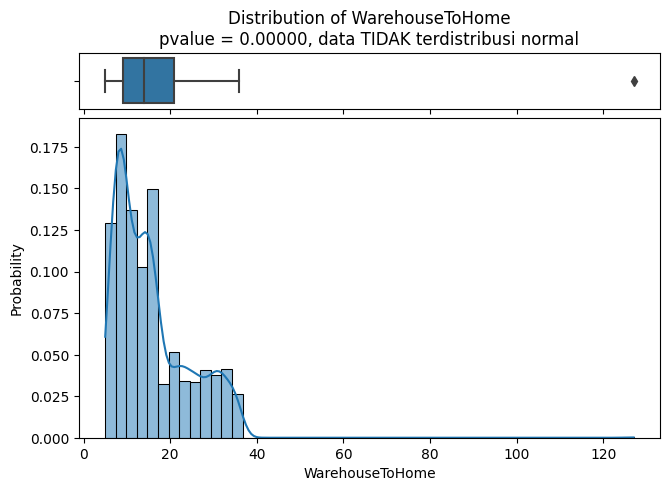

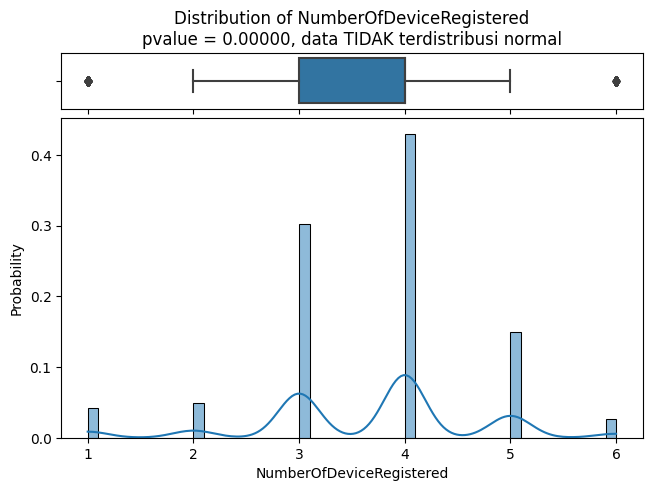

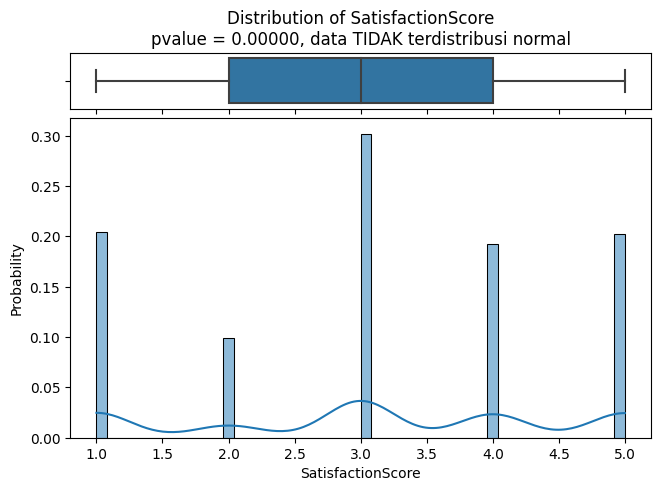

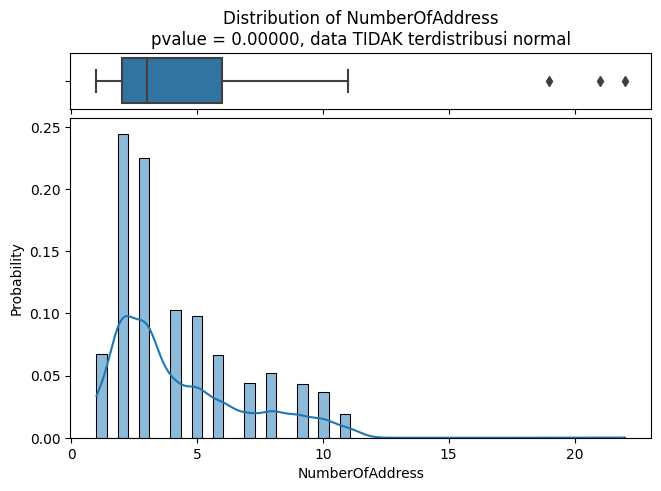

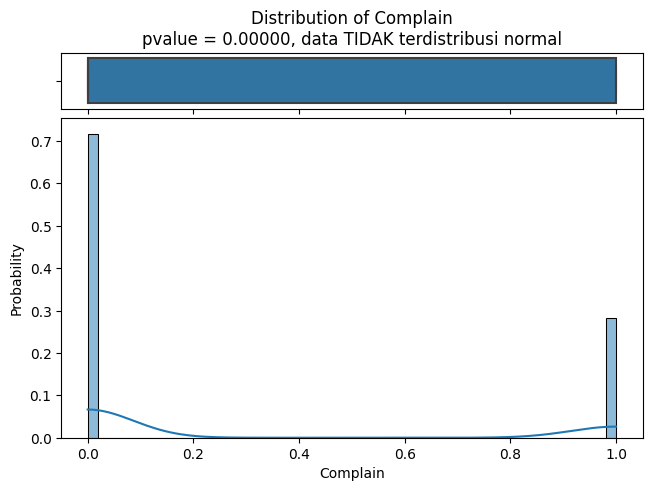

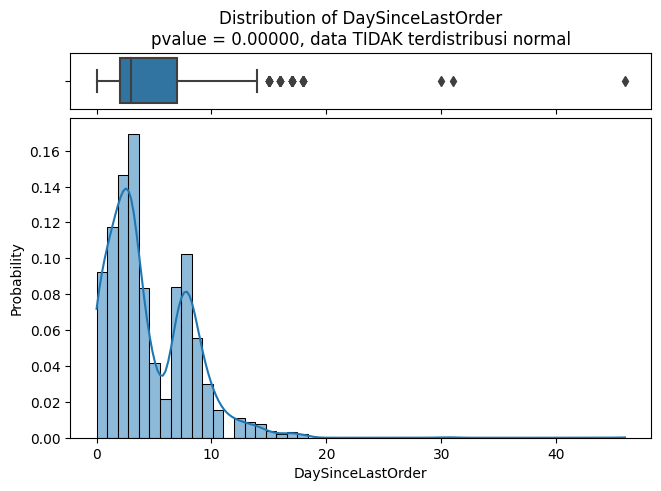

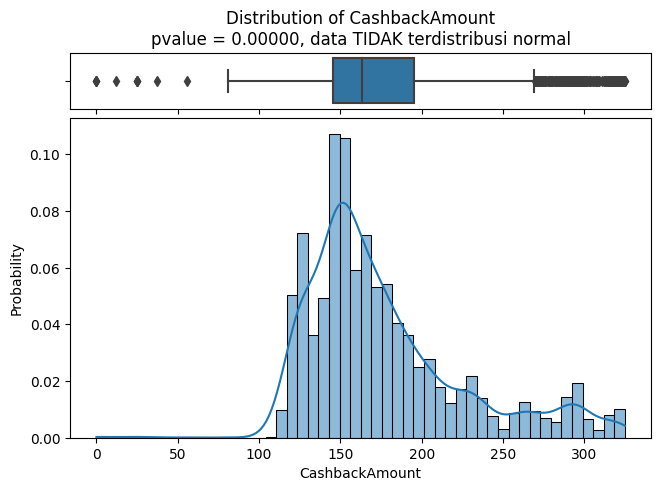

In [288]:
for kolom in numerical_features:

    fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (7.5,5), 
                                    gridspec_kw={"height_ratios": (.15, .85),
                                                "hspace": 0.05})

    stat, pvalue = normaltest(df[kolom].dropna())

    if pvalue > 0.05 :
        distribusi = f'pvalue = {pvalue:.5f}, data terdistribusi normal'
    else :
        distribusi = f'pvalue = {pvalue:.5f}, data TIDAK terdistribusi normal'

    ax1.set_title(f"Distribution of {kolom}\n{distribusi}", color = "black")
    sns.boxplot(x = df[kolom], ax = ax1)
    ax1.set(xlabel = "")

    sns.histplot(data = df[kolom], ax = ax2, stat = "probability", kde=True, bins=50)

    plt.show()

In [289]:
stat, pvalue = shapiro(df['CashbackAmount'])

if pvalue > 0.05 :
    print(f'pvalue = {pvalue:.5f}, kita mengasumsikan data terdistribusi normal')
else :
    print(f'pvalue = {pvalue:.5f}, kita mengasumsikan data TIDAK terdistribusi normal')

pvalue = 0.00000, kita mengasumsikan data TIDAK terdistribusi normal


**Categorical Features**

In [290]:
categorical_features = df.describe(include='object').columns

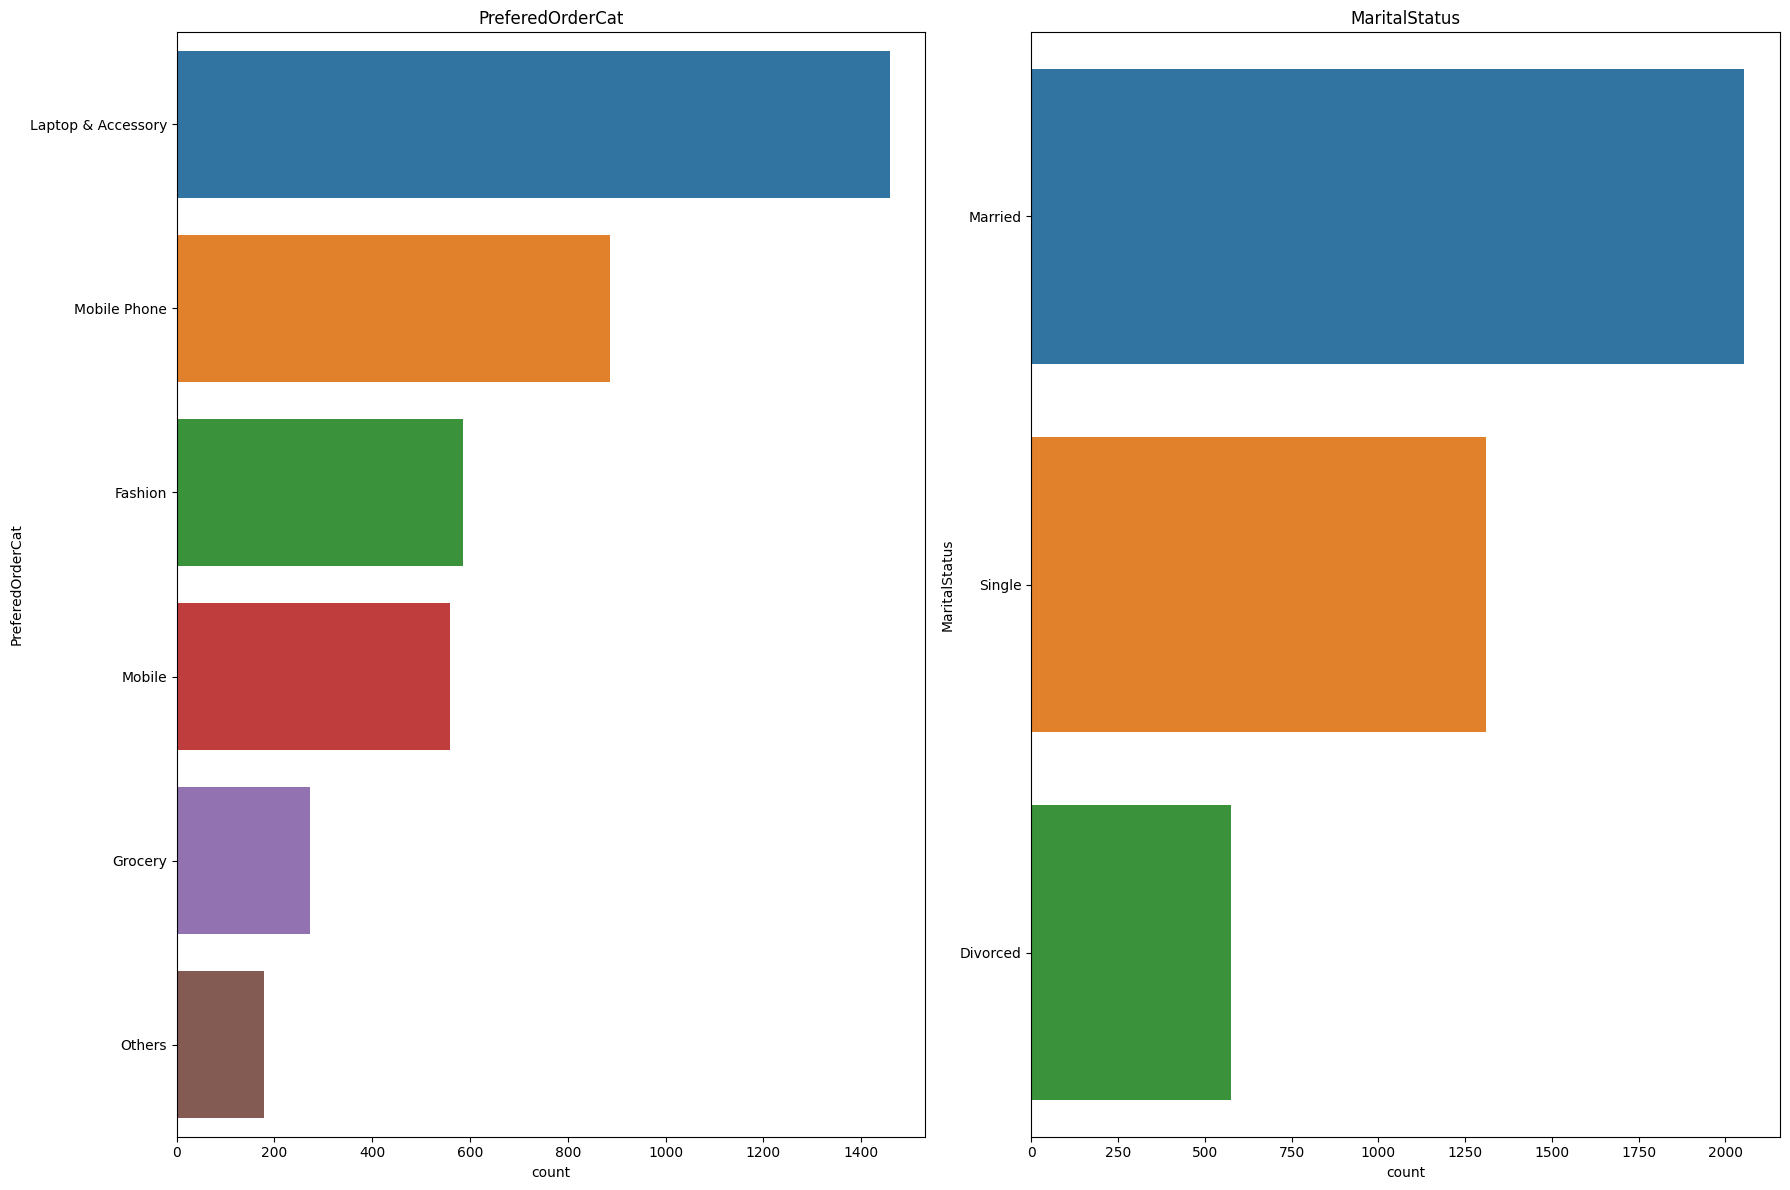

In [291]:
fig, axes = plt.subplots(1, 2, figsize=(18, 12)) 
for i, j in zip(categorical_features, axes.flatten()):
    ax = sns.countplot(data=df, y= i, ax= j, order=df[i].value_counts().index)
    ax.set_title(f'{i}',size = 12) 
plt.tight_layout()

plt.show()

**Data Correlation**

In [292]:
matriks = np.triu(df[df.describe().columns].corr(method='spearman'))

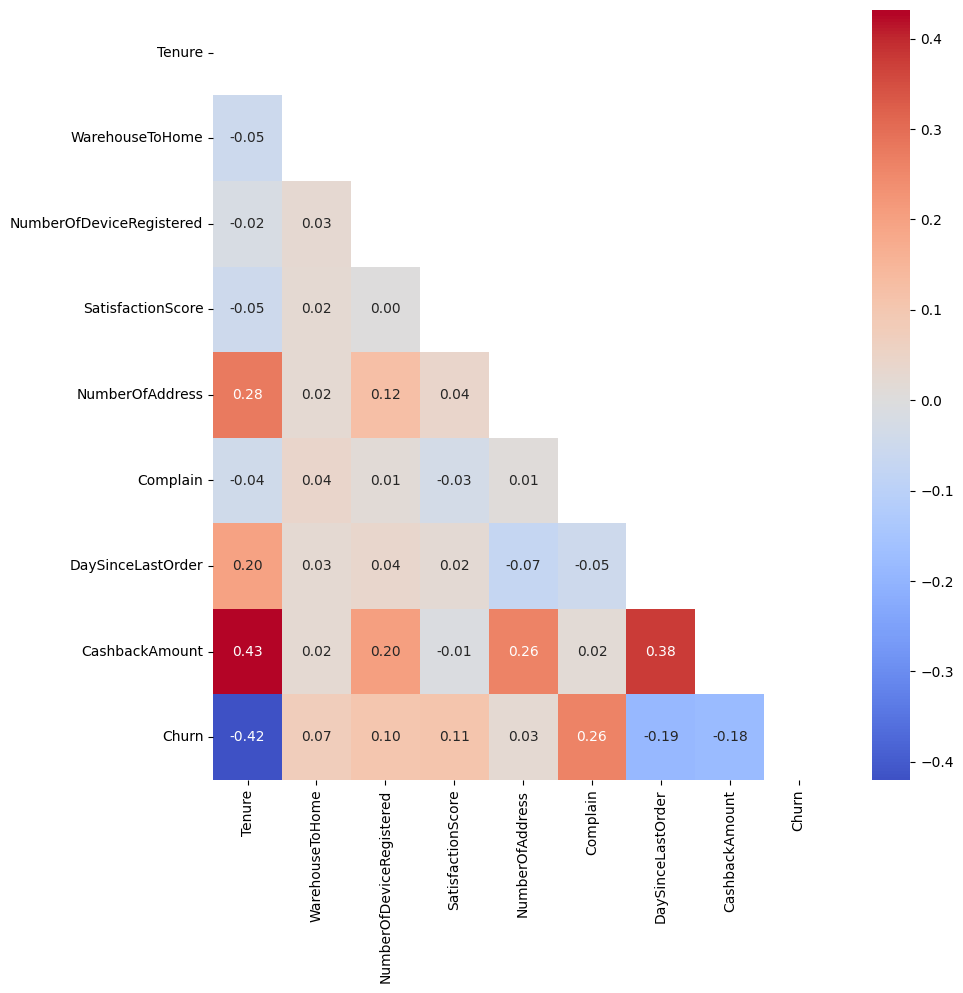

In [293]:
plt.figure(figsize=(10,10))

sns.heatmap(data=df[df.describe().columns].corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm', center=0, mask = matriks)
plt.show()

**Insight**

- Warna gelap menunjukkan korelasi yang semakin kuat.
- Warna merah gelap menunjukkan hubungan yang positif, semakin gelap maka hubungannnya positif dan semakin kuat.
- Warna pucat menunjukkan hubungan korelasi semakin lemah.
- `Tenure` dan `CashbackAmount` menunjukkan hubungan *`Weak Positive`*, semakin tinggi Tenure maka semakin tinggi `CashbackAmount` yang didapat. 
- `Churn` dan `Tenure` menunjukkan hubungan weak negative, semakin kecil `Churn` maka masa berlangganan atau `Tenure` semakin kecil. 

## **Data Preprocessing**

**Drop Duplicates**

In [294]:
df=df.drop_duplicates().reset_index(drop=True)

In [295]:
df.shape

(3270, 11)

**Handling Outliers**

In [296]:
# mencari nilai lower dan upper fence pada masing-masing kolom numerikal

list_lower = []
list_upper = []
number_lower = []
number_inside = []
number_upper = []
percentage_outlier = []

for feature in numerical_features: 
    IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    lower_fence = df[feature].quantile(0.25) - 1.5*IQR
    upper_fence = df[feature].quantile(0.75) + 1.5*IQR
    list_lower.append(lower_fence)
    list_upper.append(upper_fence)
    number_lower.append(len(df[df[feature]<lower_fence]))
    number_inside.append(len(df[(df[feature]>=lower_fence) & (df[feature]<=upper_fence)]))
    number_upper.append(len(df[df[feature]>upper_fence]))
    percentage_outlier.append(round((len(df[df[feature]<lower_fence]) + len(df[df[feature]>upper_fence])) / len(df)  *100, 2))

outliers = pd.DataFrame({
    'Kolom' : numerical_features,
    'Lower' : list_lower,
    'Upper' : list_upper,
    '# Lower' : number_lower,
    '# Inside' : number_inside,
    '# Upper' : number_upper,
    '% Outlier' : percentage_outlier
})

outliers

,Kolom,Lower,Upper,# Lower,# Inside,# Upper,% Outlier
0,Tenure,-19.000,37.000,0,3106,4,0.12
1,WarehouseToHome,-7.500,36.500,0,3134,1,0.03
2,NumberOfDeviceRegistered,1.500,5.500,137,3044,89,6.91
3,SatisfactionScore,-1.000,7.000,0,3270,0,0.00
4,NumberOfAddress,-4.000,12.000,0,3267,3,0.09
5,Complain,-1.500,2.500,0,3270,0,0.00
6,DaySinceLastOrder,-5.500,14.500,0,3049,40,1.22
7,CashbackAmount,69.025,274.005,9,3017,244,7.74


In [297]:
# proporsi target pada dataset awal
df['Churn'].value_counts()/len(df) * 100

Churn
0    83.669725
1    16.330275
Name: count, dtype: float64

In [298]:
# proporsi target untuk data outlier pada kolom Tenure
df[df['Tenure']>37]['Churn'].value_counts()/len(df[df['Tenure']>37]) * 100

Churn
0    100.0
Name: count, dtype: float64

In [299]:
# proporsi target untuk data outlier pada kolom WarehouseToHome
df[df['WarehouseToHome']>36.5]['Churn'].value_counts()/len(df[df['WarehouseToHome']>36.5]) * 100

Churn
0    100.0
Name: count, dtype: float64

In [300]:
# proporsi target untuk data outlier pada kolom NumberOfDeviceRegistered
df[df['NumberOfDeviceRegistered']>5.5]['Churn'].value_counts()/len(df[df['NumberOfDeviceRegistered']>5.5]) * 100

Churn
0    66.292135
1    33.707865
Name: count, dtype: float64

In [301]:
# proporsi target untuk data outlier pada kolom NumberOfAddress
df[df['NumberOfAddress']>12].dropna()['Churn'].value_counts()/len(df[df['NumberOfAddress']>12].dropna()) * 100

Churn
0    100.0
Name: count, dtype: float64

In [302]:
# proporsi target untuk data outlier pada kolom DaySinceLastOrder
df[df['DaySinceLastOrder']>14.5].dropna()['Churn'].value_counts()/len(df[df['DaySinceLastOrder']>14.5].dropna()) * 100

Churn
0    94.871795
1     5.128205
Name: count, dtype: float64

In [303]:
# proporsi target untuk data outlier pada kolom CashbackAmount
df[df['CashbackAmount']>274.005].dropna()['Churn'].value_counts()/len(df[df['CashbackAmount']>274.005].dropna()) * 100

Churn
0    95.491803
1     4.508197
Name: count, dtype: float64

**Handling Missing Values**

**Encoding**

In [304]:
categorical_features = df.describe(include='object').columns

In [305]:
# menampilkan jumlah unik dan unique values untuk setiap kolom
pd.set_option('display.max_colwidth', None)
# data unik di tiap kolom
listItem = []
for col in categorical_features :
    listItem.append( [col, df[col].nunique(), df.sort_values(col)[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Values'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Values
0,PreferedOrderCat,6,"[Fashion, Grocery, Laptop & Accessory, Mobile, Mobile Phone, Others]"
1,MaritalStatus,3,"[Divorced, Married, Single]"


**Insight**


Disini kita dapat melihat ada values yang sama tapi beda penulisannya maka disini kita lakukan merubah nama tersebut agar menjadi satu values **(Mobile dan Mobile Phone)**

In [306]:
df['PreferedOrderCat'] = df['PreferedOrderCat'].replace({'Mobile':'Mobile Phone'})

In [307]:
df['PreferedOrderCat'].value_counts()

PreferedOrderCat
Laptop & Accessory    1213
Mobile Phone          1183
Fashion                484
Grocery                241
Others                 149
Name: count, dtype: int64

In [308]:

transformer = ColumnTransformer([
    ('imp_median', SimpleImputer(strategy='median'), ['Tenure','WarehouseToHome','DaySinceLastOrder']),
    
    ('onehot', OneHotEncoder(drop='first'), ['MaritalStatus', 'PreferedOrderCat']),
], remainder='passthrough')

**Summary**

- Disini kita melakukan pengisian data yang miss dengan simple imputer dikarenakan data tidak terdistribusi tidak normal maka kita mengisinya dengan median.
- Dan kita merubah value di kolom 'MaritalStatus' dan 'PreferedOrderCat' menjadi kategorikal agar bisa dilakukan analisa yang diperlukan.

**Scaling**

Kita akan menggunakan Robust Scaler karena data kita memiliki outlier dan Robust Scaler tidak akan terpengaruh oleh outlier. Namun kita dapat mengatur ulang scaler nantinya untuk mendapatkan scaler terbaik.

In [309]:
# scaling features 
robust = RobustScaler()

# for tuning
standard = StandardScaler()
minmax = MinMaxScaler()


**Imbalance Data**

In [310]:
df['Churn'].value_counts()/len(df)

Churn
0    0.836697
1    0.163303
Name: count, dtype: float64

Kita dapat melihat bahwa dataset tidak seimbang (mild imbalance) karena proporsi kelas minoritas sebesar 16.33%.
Untuk mensiasati hal tersebut nantinya kita dapat menguji apakah modelling perlu menerapkan metode resampling agar data kita memiliki distribusi kelas yang lebih seimbang atau tidak.

Metode resampling yang akan dipakai adalah SMOTE. Namun kita dapat mengatur ulang resampler nantinya untuk mendapatkan resampler terbaik.

In [311]:
smote = SMOTE(random_state=0)

## **Data Analysis**

## **Define Features (X) and Target (y)**

In [312]:
# Features
X = df.drop(columns='Churn')

# target
y = df['Churn']

## **Data Splitting**

In [313]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=0,
    stratify=y
)

## **Model benchmark**

In [314]:
# Define the models
# logres
logreg = LogisticRegression()

# knn
knn = KNeighborsClassifier()

# tree
tree = DecisionTreeClassifier()
# RandomForest
rf = RandomForestClassifier()

# Adaboost
adaboost = AdaBoostClassifier()

# Gradientboost
gradboost = GradientBoostingClassifier()

# ExtremeGradientBoost
xgboost = XGBClassifier()

In [315]:
# create scorer
f2_score = make_scorer(fbeta_score, beta=2)

In [316]:
models = [logreg, knn,tree, rf, adaboost, gradboost, xgboost]

list_mean = []
list_std = []
list_score = []

for algoritma in models:

    pipe_model=Pipeline([
        ('preprocess', transformer),
        ('scaler', robust),
        ('resampler', smote),
        ('model', algoritma)
    ])

    skfold = StratifiedKFold(n_splits=5)

    model_cv = cross_val_score(
        estimator=pipe_model,
        X=X_train,
        y=y_train,
        cv=skfold,
        scoring=f2_score
    )

    list_mean.append(model_cv.mean())
    list_std.append(model_cv.std())
    list_score.append(model_cv.round(3))

In [317]:
# Perbandingan performa antar model
dftrain=pd.DataFrame({
    'model':['logreg', 'knn', 'tree', 'randomforest', 'adaboost','gradboost','xgboost'],
    'mean f2_score': list_mean,
    'std f2_score': list_std,
    'all_score' : list_score
}).sort_values('mean f2_score', ascending=False)
dftrain

,model,mean f2_score,std f2_score,all_score
6,xgboost,0.717868,0.040901,"[0.791, 0.711, 0.671, 0.692, 0.724]"
3,randomforest,0.695639,0.005711,"[0.689, 0.692, 0.692, 0.704, 0.7]"
1,knn,0.691853,0.015320,"[0.693, 0.72, 0.686, 0.686, 0.674]"
0,logreg,0.688247,0.028566,"[0.728, 0.662, 0.673, 0.661, 0.717]"
5,gradboost,0.683365,0.013739,"[0.701, 0.666, 0.693, 0.669, 0.688]"
4,adaboost,0.677085,0.015929,"[0.687, 0.661, 0.658, 0.68, 0.7]"
2,tree,0.622248,0.047900,"[0.659, 0.529, 0.638, 0.631, 0.655]"


### **Interpretasi**

- Dari ketujuh model yang dicoba, ternyata model XGBoost menghasilkan nilai mean_f2_score yang paling besar.
- model dengan nilai terbesar adalah Xgboost dengan nilai 0.717 sedangkan yang terkecil adalah model decission tree dengan nilai 0.625.

 Mari kita coba cek performa dari tiga model teratas yang ada pada tabel diatas pada test set.

## **Predict Benchmark Model to Test Set**

In [318]:
bestmodels= [knn, rf, xgboost]

In [319]:
list_f2_score = []

# Mencari model terbaik berdasarkan f2 score terbesar dan std terkecil
for algoritma in bestmodels :

    pipe_model=Pipeline([
        ('preprocess', transformer),
        ('scaler', robust),
        ('resampler', smote),
        ('model', algoritma)
    ])

    # fitting
    pipe_model.fit(X_train, y_train)

    # predict
    y_pred = pipe_model.predict(X_test)

    # evaluate
    score = fbeta_score(y_test, y_pred, beta=2)
    list_f2_score.append(score)

In [320]:
# Perbandingan performa antar model
dfpredik=pd.DataFrame({
    'model':['knn', 'randomforest', 'xgboost'],
    'f2_score (test_set)': list_f2_score
}).sort_values('f2_score (test_set)', ascending=False)
dfpredik


,model,f2_score (test_set)
1,randomforest,0.716946
0,knn,0.703883
2,xgboost,0.693161


Berdasarkan hasil prediksi pada test set, terlihat bahwa Random Forest memiliki score yang lebih baik dan juga terhitung stabil pada data set ini sedangkan XGBoost terjadi penurunan performa.


## **Hyperparameter Tuning**

**Random Forest**

In [321]:
# kedalaman pohon
max_depth = list(np.arange(1, 11))

# jumlah features
max_features = list(np.arange(2, 200, 1))

# minimum samples sebelum splitting pada node
min_samples_split = list(np.arange(2, 21, 1))

# minimum samples setelah splitting pada leaf
min_samples_leaf = list(np.arange(1, 21, 1)) 

# jumlah pohon
n_estimators = list(np.arange(100,201))

# Hyperparam space Random Forest
hyperparam_space_rf = {
    'model__max_depth':max_depth, 
    'model__min_samples_split':min_samples_split, 
    'model__min_samples_leaf':min_samples_leaf, 
    'model__max_features':max_features,
    'model__n_estimators':n_estimators
}

In [322]:
# Benchmark model 1
rf = RandomForestClassifier(random_state=0)

# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

# Create the algorithm chains
estimator_rf = Pipeline([
    ('preprocess', transformer),
    ('scaler', robust),
    ('resampler', smote), 
    ('model', rf)
    ])

# Hyperparameter tuning
random_rf = RandomizedSearchCV(
    estimator=estimator_rf, 
    param_distributions = hyperparam_space_rf, 
    cv = skf, 
    scoring = f2_score, 
    n_jobs = -1, 
    random_state=0,
    n_iter=2000
)

In [323]:
# fitting 
random_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('imp_median',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['Tenure',
                                                                                'WarehouseToHome',
                                                                                'DaySinceLastOrder']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['MaritalStatus',
                                                                                'PreferedOrderCat'])...
                                        'model__min_samples_leaf': [1, 2, 3, 4,
                                                                    5, 6, 7, 8,
                                                                    9, 10, 11,
                                                                    12, 13, 14,
                                                                    15, 16, 17,
                                                                    18, 19,
                                                                    20],
                                        'model__min_samples_split': [2, 3, 4, 5,
                                                                     6, 7, 8, 9,
                                                                     10, 11, 12,
                                                                     13, 14, 15,
                                                                     16, 17, 18,
                                                                     19, 20],
                                        'model__n_estimators': [100, 101, 102,
                                                                103, 104, 105,
                                                                106, 107, 108,
                                                                109, 110, 111,
                                                                112, 113, 114,
                                                                115, 116, 117,
                                                                118, 119, 120,
                                                                121, 122, 123,
                                                                124, 125, 126,
                                                                127, 128, 129, ...]},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=2))

In [324]:
# score randomforest terbaik
random_rf.best_score_

0.7372912149697559

**KNN**

In [325]:
# kedalaman pohon
max_depth = list(np.arange(1, 11))

# jumlah features
max_features = list(np.arange(2, 200, 1))

# minimum samples sebelum splitting pada node
min_samples_split = list(np.arange(2, 21, 1))

# minimum samples setelah splitting pada leaf
min_samples_leaf = list(np.arange(1, 21, 1)) 

# jumlah pohon
n_estimators = list(np.arange(100,201))

# Hyperparam space Random Forest
hyperparam_space_knn = {
     'model__n_neighbors':range(1,30,2),
    'model__weights':['uniform', 'distance'],         
    'scaler': [minmax, standard, robust],
    'resampler' : [smote]        
}                                  

In [326]:
# Benchmark model 2
knn =  KNeighborsClassifier(n_neighbors=5)
# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

# Create the algorithm chains
estimator_knn = Pipeline([
    ('preprocess', transformer),
    ('scaler', robust),
    ('resampler', smote), 
    ('model', knn)
    ])

# Hyperparameter tuning
random_knn = RandomizedSearchCV(
    estimator=estimator_knn, 
    param_distributions = hyperparam_space_knn, 
    cv = skf, 
    scoring = f2_score, 
    n_jobs = -1, 
    random_state=0,
    n_iter=2000
)

In [327]:
# fitting 
random_knn.fit(X_train, y_train)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 90 is smaller than n_iter=2000. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('imp_median',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['Tenure',
                                                                                'WarehouseToHome',
                                                                                'DaySinceLastOrder']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['MaritalStatus',
                                                                                'PreferedOrderCat'])...
                                             ('scaler', RobustScaler()),
                                             ('resampler',
                                              SMOTE(random_state=0)),
                                             ('model',
                                              KNeighborsClassifier())]),
                   n_iter=2000, n_jobs=-1,
                   param_distributions={'model__n_neighbors': range(1, 30, 2),
                                        'model__weights': ['uniform',
                                                           'distance'],
                                        'resampler': [SMOTE(random_state=0)],
                                        'scaler': [MinMaxScaler(),
                                                   StandardScaler(),
                                                   RobustScaler()]},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=2))

In [328]:
# score recall terbaik
random_knn.best_score_

0.7073754334855148

**XGBoost**

In [329]:
# kedalaman pohon
max_depth = list(np.arange(1,11))

# learning rate
learning_rate = list(np.arange(0.01, 1.0, 0.01))

# jumlah pohon
n_estimators = list(np.arange(100,201))

# jumlah baris tiap pohon (% dari total baris train set)
subsample = list(np.arange(0.2, 1.0, 0.1))

# gamma (min_impurity_decrease)
gamma = list(np.arange(1,11))

# jumlah feature yang digunakan untuk tiap pohon (% dari total kolom train set)
colsample_bytree = list(np.arange(0.1, 1.0, 0.2))

# alpha (regularization)
reg_alpha = list(np.logspace(-3,3,7))


# Hyperparam space XGboost
hyperparam_space_xgboost = {
    'balancing':[smote, None],
    'model__max_depth':max_depth, 
    'model__learning_rate':learning_rate,
    'model__n_estimators':n_estimators,
    'model__subsample':subsample,
    'model__gamma':gamma,
    'model__colsample_bytree':colsample_bytree,
    'model__reg_alpha': reg_alpha
}

In [330]:
# Benchmark model 3
xgboost = XGBClassifier(random_state=0, verbosity=0)

# Create the algorithm chains
estimator_xgboost = Pipeline([
        ('tansformer', transformer),
        ('balancing', smote), 
        ('model', xgboost)
        ])

# Hyperparameter tuning
random_xgboost = RandomizedSearchCV(
    estimator_xgboost, 
    param_distributions = hyperparam_space_xgboost, 
    cv = skf, 
    scoring = f2_score, 
    n_jobs = -1,  
    random_state=0,
    n_iter=2000
)

In [331]:
# fitting 
random_xgboost.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('tansformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('imp_median',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['Tenure',
                                                                                'WarehouseToHome',
                                                                                'DaySinceLastOrder']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['MaritalStatus',
                                                                                'PreferedOrderCat'])...
                                                                112, 113, 114,
                                                                115, 116, 117,
                                                                118, 119, 120,
                                                                121, 122, 123,
                                                                124, 125, 126,
                                                                127, 128, 129, ...],
                                        'model__reg_alpha': [0.001, 0.01, 0.1,
                                                             1.0, 10.0, 100.0,
                                                             1000.0],
                                        'model__subsample': [0.2,
                                                             0.30000000000000004,
                                                             0.4000000000000001,
                                                             0.5000000000000001,
                                                             0.6000000000000001,
                                                             0.7000000000000002,
                                                             0.8000000000000003,
                                                             0.9000000000000001]},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=2))

In [332]:
# score f2 terbaik
random_xgboost.best_score_

0.6912528108533007

**Summary**

Performa model Random Forest, KNN dan Xgboost pada train set menjadi:
| Model | Sebelum Tuning | Setelah Tuning |
|--|--|--|
|Random Forest| 0.699 | 0.737 |
|KNN| 0.692 | 0.707 |
|XGBoost| 0.717 | 0.691 |

Dari data diatas ini kita bisa melihat bahwa:
- Random Forest mengalami peningkatan dari 70.6% menjadi 73.7% 
- KNN mengalami peningkatan dari 69.2% menjadi 70.7%
- XGBoost mengalami penurunan dari 71.7% menjadi 69.1%.

Mari kita coba pada model - model ini ke test set.

## **Predict to Test Set**

**Random Forest**

In [333]:
# menggunakan model terbaik hasil randomizedsearch
tuned_model = random_rf.best_estimator_

# fitting
tuned_model.fit(X_train, y_train)

# predict
y_pred_rf_tuned = tuned_model.predict(X_test)

# evaluate 
fbeta_score(y_test, y_pred_rf_tuned, beta=2)

0.7534246575342465

**KNN**

In [334]:
# menggunakan model terbaik hasil randomizedsearch
tuned_model = random_knn.best_estimator_

# fitting
tuned_model.fit(X_train, y_train)

# predict
y_pred_knn_tuned = tuned_model.predict(X_test)

# evaluate (f1-score)
fbeta_score(y_test, y_pred_knn_tuned, beta=2)

0.7258064516129032

**XGBoost**

In [335]:
# menggunakan model terbaik hasil randomizedsearch
tuned_model1 = random_xgboost.best_estimator_

# fitting
tuned_model1.fit(X_train, y_train)

# predict
y_pred_xgboost_tuned = tuned_model1.predict(X_test)

# evaluate 
fbeta_score(y_test, y_pred_xgboost_tuned, beta=2)

0.6525911708253359

Performa Random Forest, KNN dan XGBoost pada test set sebelum tuning dan sesudah tuning:
| Model | Sebelum Tuning | Setelah Tuning |
|--|--|--|
|Random Forest| 0.725 | 0.753 |
|KNN| 0.704 | 0.726 |
|XGBoost| 0.693 | 0.652 |


Setelah dilakukan hyperparameter tuning performa:
- Random Forest pada test set terjadi kenaikan menjadi 71.5% dari 75.3% 
- KNN juga mengalami peningakatan pada test set ini menjadi 72.6% dari 70.4%
- Sedangkan XGboost mengalami penurunan dari 69.3% menjadi 65.2%. 

Dikarenakan adanya peningkatan dan kestabilan pada rentang di Random Forest, maka dari itu kita memilih Random Forest sebagai model yang dipilih.

In [336]:
print(classification_report(y_test, y_pred_rf_tuned))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       547
           1       0.56      0.82      0.67       107

    accuracy                           0.87       654
   macro avg       0.76      0.85      0.79       654
weighted avg       0.90      0.87      0.88       654



## **Model Properties**

**Feature Importances**

In [337]:
final_model=random_rf.best_estimator_

In [338]:
feature_simpleimputer= list(final_model[0].transformers_[0][2])
feature_onehot = list(final_model[0].transformers_[1][1].get_feature_names_out())
feature_remainder = list(X.columns[final_model[0].transformers_[2][2]])

feature_names = feature_simpleimputer+feature_onehot + feature_remainder

In [339]:
df_importances = pd.DataFrame({
    'features' : feature_names,
    'importance' : final_model['model'].feature_importances_
}).sort_values('importance', ascending=False)
df_importances


,features,importance
0,Tenure,0.407710
12,Complain,0.163693
13,CashbackAmount,0.059988
2,DaySinceLastOrder,0.059541
11,NumberOfAddress,0.059497
7,PreferedOrderCat_Mobile Phone,0.055574
10,SatisfactionScore,0.050088
3,MaritalStatus_Married,0.049355
1,WarehouseToHome,0.027557
6,PreferedOrderCat_Laptop & Accessory,0.025108


### **Save Model**

In [340]:
import pickle

In [341]:
# saving model

# best model
final_model = random_rf.best_estimator_

# fitting to all data
final_model.fit(X, y)

# save
pickle.dump(final_model, open('model_randomforest_for_churn_classification.sav', 'wb'))

In [342]:
# load model
model_loaded_pickle = pickle.load(open('model_randomforest_for_churn_classification.sav', 'rb'))

**Predict (to existing data)**

In [343]:
# predict to user 900
X_test.iloc[[2]]

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount
900,1.0,32.0,6,Mobile Phone,3,Single,3,0,2.0,147.93


In [344]:
# actualnya churn
y_test.iloc[2]

1

Disini kita akan mencoba prediksi pada data 900 dimana baris data ini aktualnya 'churn'

In [345]:
# prediction result for user 900
model_loaded_pickle.predict(X_test.iloc[[2]])

# user 900 diprediksi akan churn

array([1], dtype=int64)

Dan setelah di test maka data 900 diprediksi akan 'churn'

# **Kesimpulan dan Rekomendasi**

# **Kesimpulan**

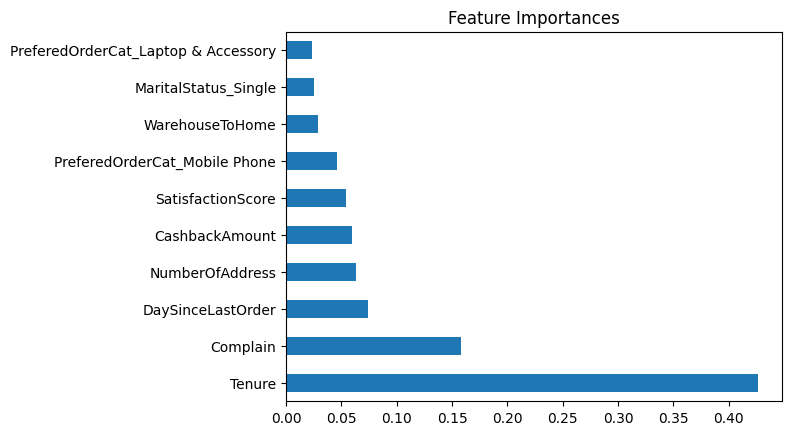

In [346]:
coef1 = pd.Series(final_model['model'].feature_importances_, feature_names).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

**Insight**

- Pada Model Random Forest ini, Tenure menjadi salah satu faktor yang paling penting dikarenakan Tenure ini sangat berdampak pada pelanggan `**churn**`.
- Pada grafik plot ini, secara umum terlihat bahwa semakin kecil Tenure artinya pelanggan tersebut akan **join promo** yang dilakukan oleh perusahaan E-Commerce ini, maka hal itu sangat berpengaruh terhadap pelanggan churn dan berlaku juga sebaliknya.
- Faktor Complain juga termasuk fitur yang cukup penting. Semakin tinggi nilai complain (jika pelanggan melakukan complain), maka dapat berdampak pada pelanggan untuk churn.
- Begitu juga untuk faktor-faktor lainnya yang berpengaruh setelah Tenure dan Complain, semakin tinggi nilai maka dapat berdampak pada pelanggan churn


Berdasarkan Feature Importance dan Summary Plot, 3 Faktor utama yang mempengaruhi prediksi pelanggan Churn secara berurutan adalah

- Tenure : Semakin kecil nilai Tenure artinya pelanggan yang baru berlangganan meiliki kemungkinan besar pelanggan akan churn dan semakin lama pelanggan berlangganan ada kemungkian sudah nyaman terhadap layanan perusahaan.
- Complain : Semakin besar nilai Complain semakin besar kemungkinan pelanggan akan Churn dan sebaliknya. nilai yang besar artinya pelanggan melakukan complain atau pelanggan tidak puas terhadap layanan.
- CashbackAmount : Semakin besar nilai CashbackAmount semakin besar kemungkinan pelanggan akan tidak akan Churn dan sebaliknya. Karena dengan tawaran cashback yang kecil memungkinkan pelanggan tidak tertarik dan bisa mengakibatkan akan churn.

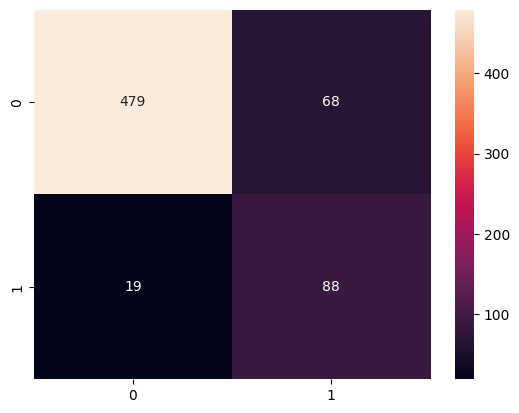

In [347]:

confusion_matrix(y_test, y_pred_rf_tuned)
sns.heatmap(confusion_matrix(y_test, y_pred_rf_tuned), annot=True, fmt='g');

Berdasarkan confusion matrix pada test set di atas terlihat bahwa dengan model yang telah kita buat didapati:
- Jumlah calon pelanggan yang aktualnya churn dan diprediksi akan churn **(True Positive)** : 88 orang
- Jumlah calon pelanggan yang aktualnya churn tetapi diprediksi tidak akan churn **(False Negative)** : 19 orang
- Jumlah calon pelanggan yang aktualnya tidak churn dan diprediksi tidak akan churn **(True Negative)** : 479 orang
- Jumlah calon pelanggan yang aktualnya tidak churn tetapi diprediksi akan churn **(False Positive)** : 68 orang

---
Berdasarkan asumsi yang telah disampaikan pada bagian Business Understanding, kita asumsikan dampak biayanya sebagai berikut :
- Biaya retensi per pelanggan --> $50 per bulan per pelanggan
- Biaya akibat kehilangan pelanggan (Churn) -->  $250 per bulan per pelanggan (total pendapatan yang hilang dan biaya (Customer Acquisition Cost)

Saat kita tidak menggunakan machine learning, kita tidak dapat memprediksi pelanggan yang akan Churn atau tidak. Dampaknya adalah kita cenderung untuk memberi program retensi kepada seluruh pelanggan.

Jumlah calon pelanggan untuk dasar perhitungan :
- calon pelanggan yang kita berikan program retensi = 654 orang
- calon pelanggan yang aktualnya churn = 107 orang

Cost Estimation
- 654 orang x $50 per bulan per pelanggan + 107 orang x $250 per bulan per pelanggan = ($32,700 + $26750)/bulan = $59,450 per bulan

Maka kerugiannya sekitar **$59,450 per bulan** bila kita tidak menggunakan machine learning.

---
Saat kita menggunakan machine learning, kita hanya menawarkan program retensi ke calon pelanggan yang diprediksi akan churn saja.

Jumlah calon pelanggan untuk dasar perhitungan :
- calon pelanggan yang kita berikan program retensi = TP + FP = 88 + 68 = 156 orang
- calon pelanggan yang aktualnya churn = 107 orang


Cost Estimation
- 156 orang x $50 per bulan per pelanggan + 107 orang x $250 per bulan per pelanggan = ($7800 + $26,750)/bulan = $34,550 per bulan

Maka kerugiannya sekitar **$34,550 per bulan** dengan menggunakan machine learning

---
**Penurunan Potential Loss** = $59,450 - $34,550 = **$24,900** per bulan

**% Penurunan** = $24,900 / 59450 x 100 = **41.9%**

Berdasarkan test set, model kita dapat menurunkan kerugian akibat churn hingga **`41.9%`** dalam sebulan dengan menggunakan **Machine Learning**.



# **Rekomendasi**

Customer yang melakukan churn dapat menimbulkan kerugian bagi perusahaan.

- perusahaan e-commerce perlu menyusun strategi agar dapat tetap menjaga kualitas produk dan pelayanan agar dapat menghindari complain yang masuk.
- perusahaan e-commerce perlu menyusun strategi agar dapat menciptakan loyalitas pelanggan, baik dengan melakukan inovasi pada produk yang dipasarkan dan memberikan penawaran yang menarik, sehingga tenure customer semakin tinggi.
- perusahaan e-commerce perlu memahami Marketing Funnel. Marketing Funnel adalah sebuah konsep untuk menjelaskan tahapan yang dilalui oleh pelanggan sebelum akhirnya melakukan pembelian produk. Dengan mengetahui dan memahami Marketing Funnel, maka sebuah perusahaan akan lebih mudah untuk mengidentifikasi penyebab pelanggan membatalkan pembelian, sehingga dapat menyusun strategi untuk dapat mengatasinya.
- Perusahaan perlu menggunakan machine learning yang sudah dibuat, agar dapat mengurangi kerugian bagi perusahaan dengan memberikan promosi tepat sasaran kepada customer yang akan melakukan churn.


## **Save Model**

### **pickle**

In [348]:
# saving model

# best model
final_model = random_rf.best_estimator_

# fitting to all data
final_model.fit(X, y)

# save
pickle.dump(final_model, open('model_rf_for_churn_classification.sav', 'wb'))